In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import time
import pickle

In [2]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
classes = {2:'GAL', 1:'QSO', 0:'STAR'}

In [5]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2
    
upsampling      = 'SMOTE'
fac             = 10

In [6]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2, RUN)), allow_pickle=True)
decoded_train,decoded_valid, decoded_test, mean, std = np.load(os.path.join(root_decoded,'decoded_%s.npy'%label_2), allow_pickle=True)

In [7]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
train_x = torch.Tensor(encoded_train).to(device) 
train_y = torch.Tensor(train['subclass']).to(torch.long).to(device)

valid_x = torch.Tensor(encoded_valid).to(device) 
valid_y = torch.Tensor(valid['subclass']).to(torch.long).to(device)

test_x = torch.Tensor(encoded_test).to(device) 
test_y = torch.Tensor(test['subclass']).to(torch.long).to(device)

In [9]:
model = torch.load(os.path.join(root_models,'conditional_SINF_%s_%s_%d'%(label_2,upsampling,fac)))

In [10]:
test.keys()

dict_keys(['spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'SN', 'MJD', 'plate', 'fiber', 'mean', 'std'])

## Analyze class 0 only



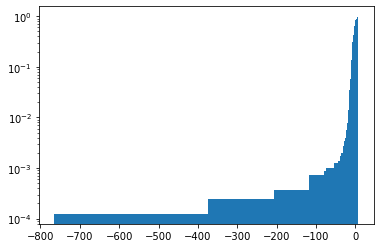

Anomalous Spectra


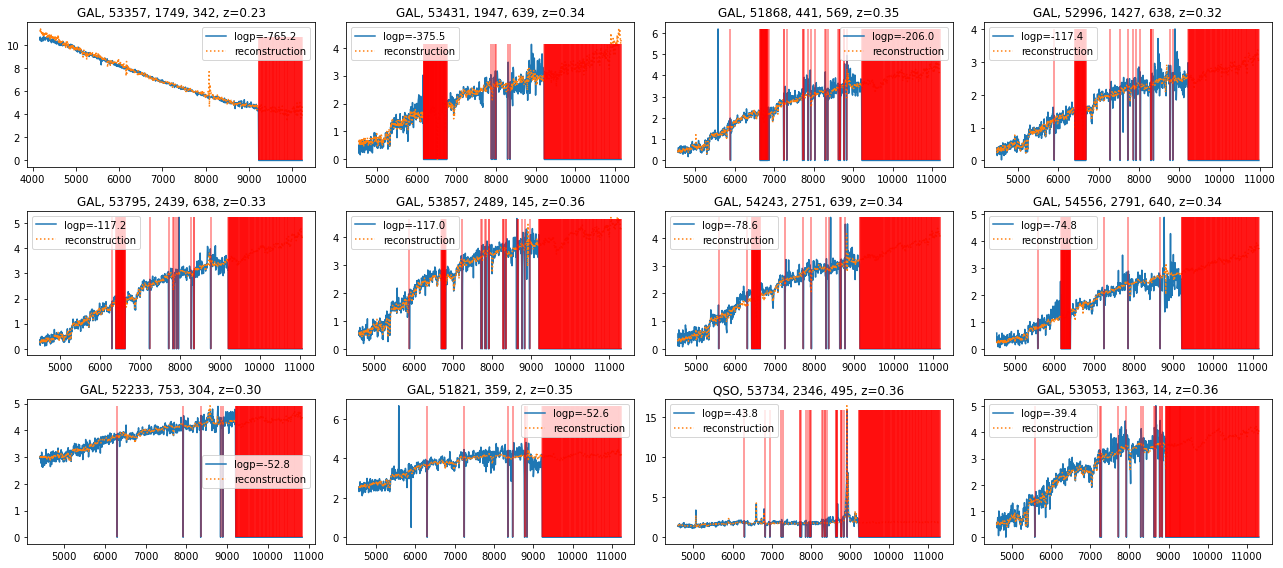

Most Normal Spectra


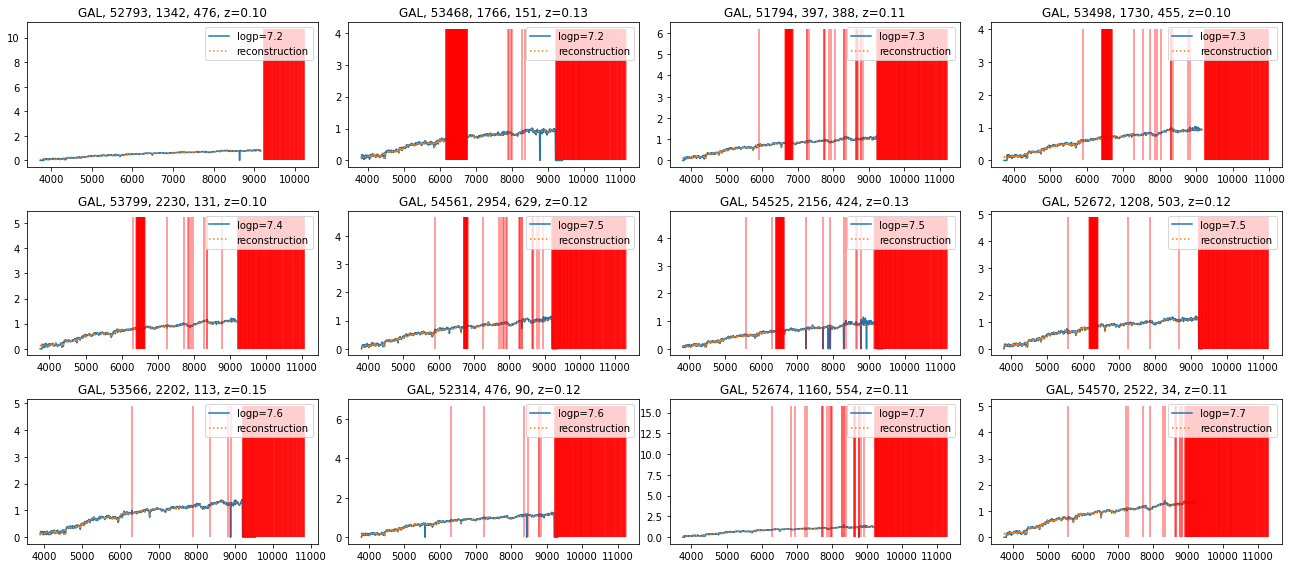

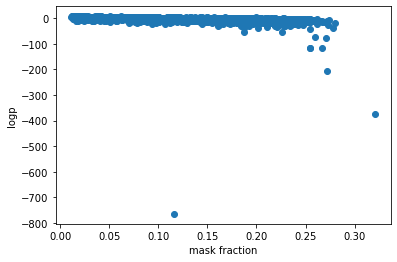

In [37]:
ind = np.where(test['subclass']==0)[0]

dens            = model.evaluate_density(test_x[ind],test_y[ind]).cpu().numpy()
ind_ood         = np.argsort(dens)
dens_sorted     = dens[ind_ood]
test_x_sorted   = test_x[ind][ind_ood].cpu().numpy()


cum, bins, _      = plt.hist(dens_sorted,bins=500,density=True, cumulative=True, log=True)
plt.show()

outliers_decoded  = decoded_test[ind][ind_ood]
outliers_input    = test['spec'][ind][ind_ood]

wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)


print('Anomalous Spectra')
fi, ax = plt.subplots(3,4,figsize=(18,8))
ax = ax.flatten()
for ii in range(12):
    ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ind_ood][ii]], test['MJD'][ind][ind_ood][ii],test['plate'][ind][ind_ood][ii],test['fiber'][ind][ind_ood][ii],test['z'][ind][ind_ood][ii]))
    ax[ii].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f'%dens_sorted[ii])
    ax[ii].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls=':')
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~test['mask'][ind][ind_ood][ii].astype(bool))]*(1+test['z'][ind][ind_ood][ii]), ymin=0,ymax=max(test['spec'][ind][ind_ood][ii]), color='red',alpha=0.5,zorder=4)
    ax[ii].legend()
plt.tight_layout()
plt.show()

print('Most Normal Spectra')
fi, ax = plt.subplots(3,4,figsize=(18,8))
ax = ax.flatten()
for nn, ii in enumerate(range(len(ind_ood)-12,len(ind_ood))):
    ax[nn].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ind_ood][ii]], test['MJD'][ind][ind_ood][ii],test['plate'][ind][ind_ood][ii],test['fiber'][ind][ind_ood][ii],test['z'][ind][ind_ood][ii]))
    ax[nn].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f'%dens_sorted[ii])
    ax[nn].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls=':')
    ax[nn].vlines( x=new_wl[1:][np.squeeze(~test['mask'][ind][ind_ood][nn].astype(bool))]*(1+test['z'][ind][ind_ood][nn]), ymin=0,ymax=max(test['spec'][ind][ind_ood][nn]), color='red',alpha=0.5,zorder=4)
    ax[nn].legend()
plt.tight_layout()
plt.show()

mask_fracs = np.sum(~test['mask'].astype('bool'),axis=1)/1000

plt.xlabel('mask fraction')
plt.ylabel('logp')
plt.scatter(mask_fracs[ind][ind_ood],dens_sorted)
plt.show()

subclass b'AGN'


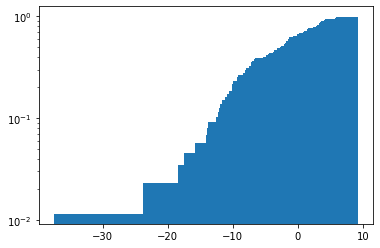

Anomalous Spectra


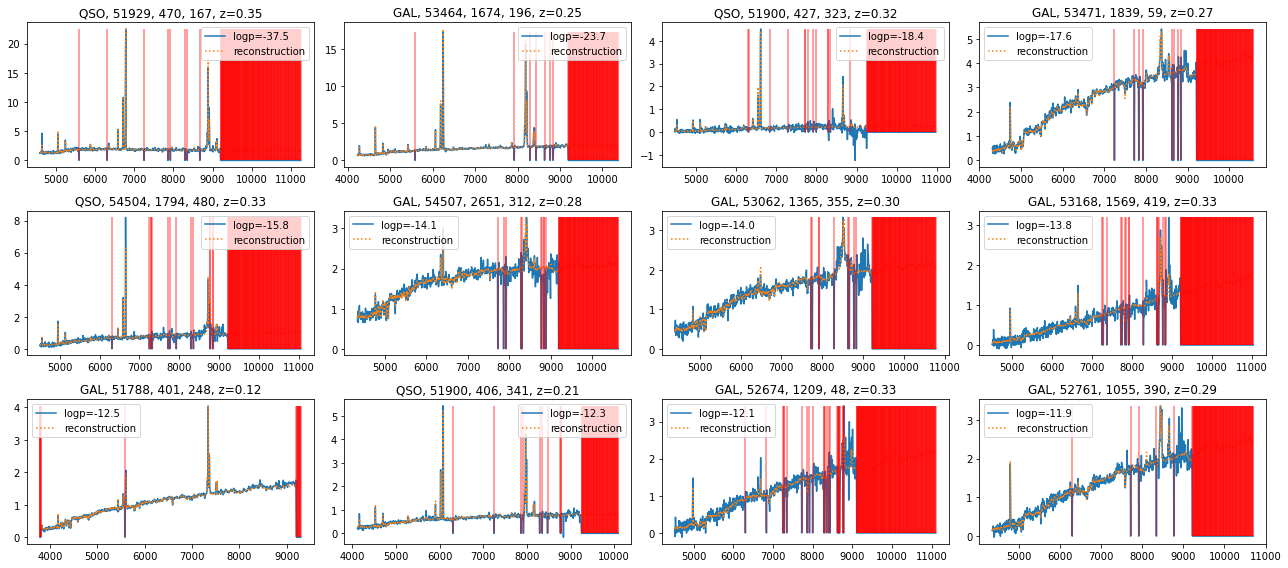

Most Normal Spectra


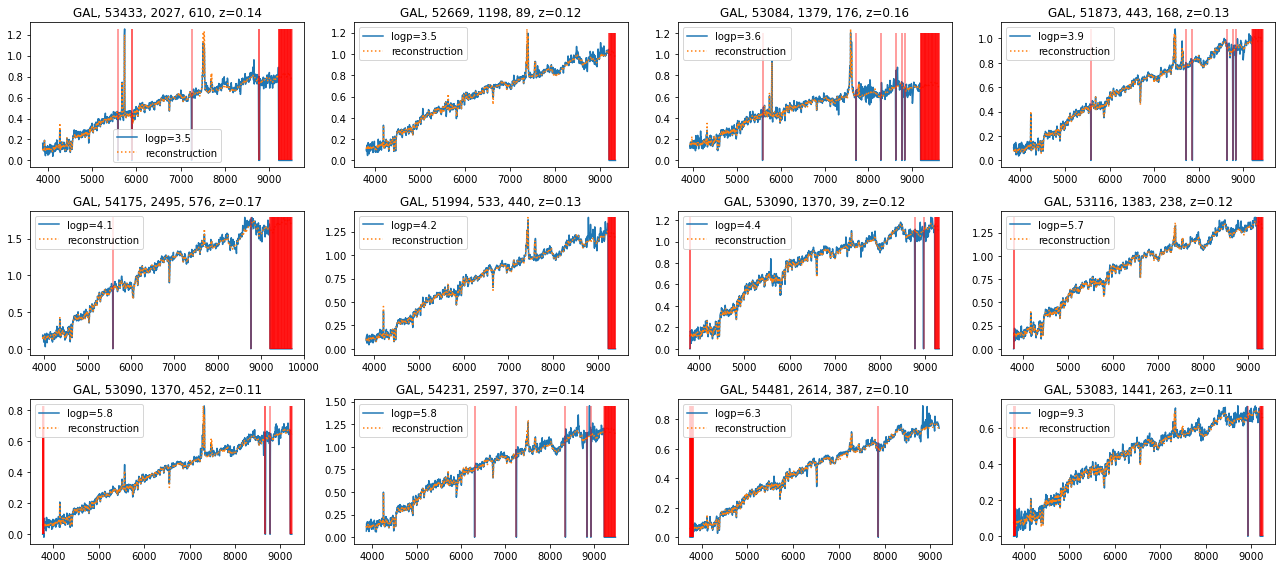

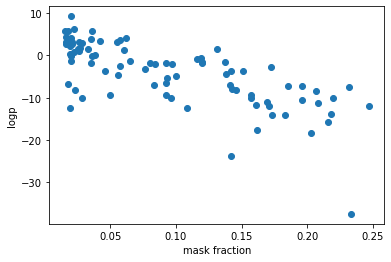

subclass b'AGN BROADLINE'


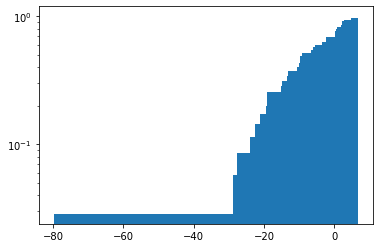

Anomalous Spectra


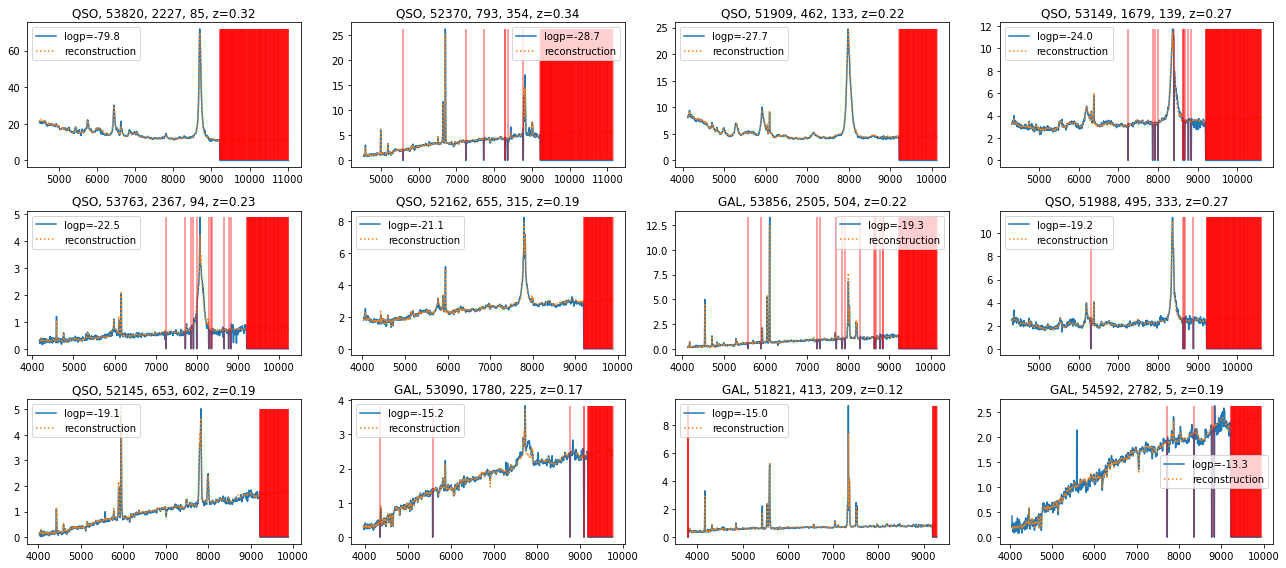

Most Normal Spectra


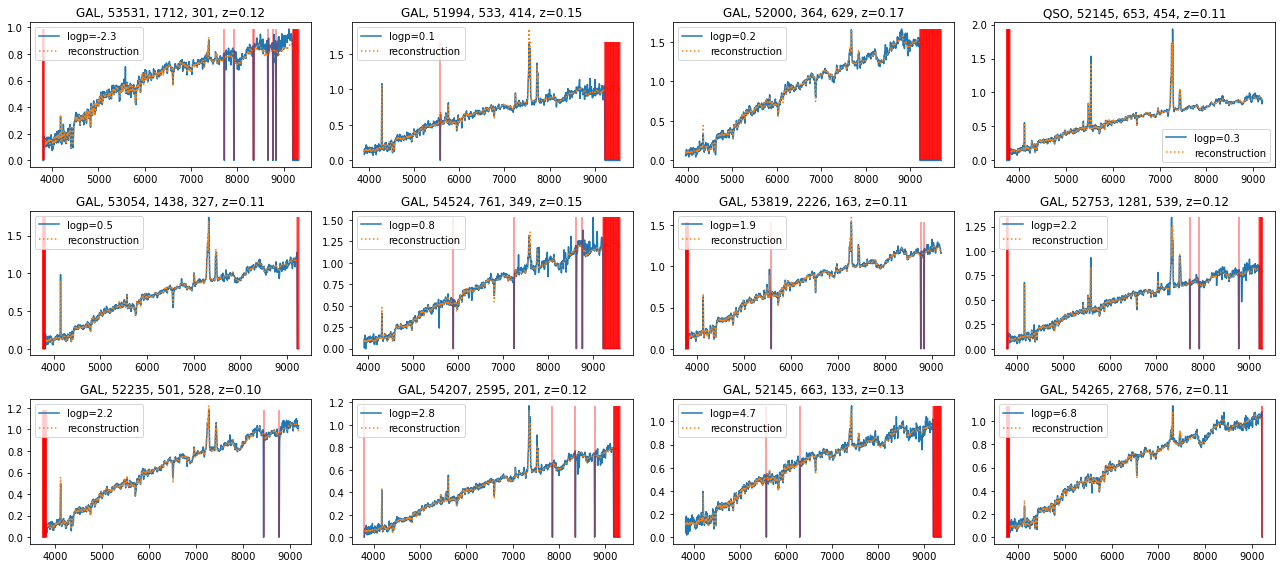

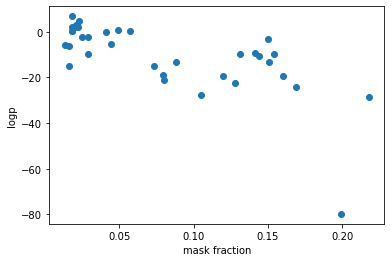

subclass b'BROADLINE'


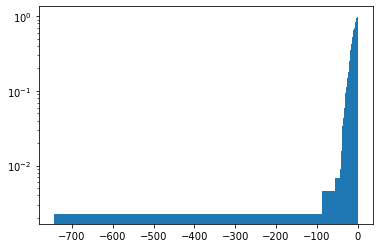

Anomalous Spectra


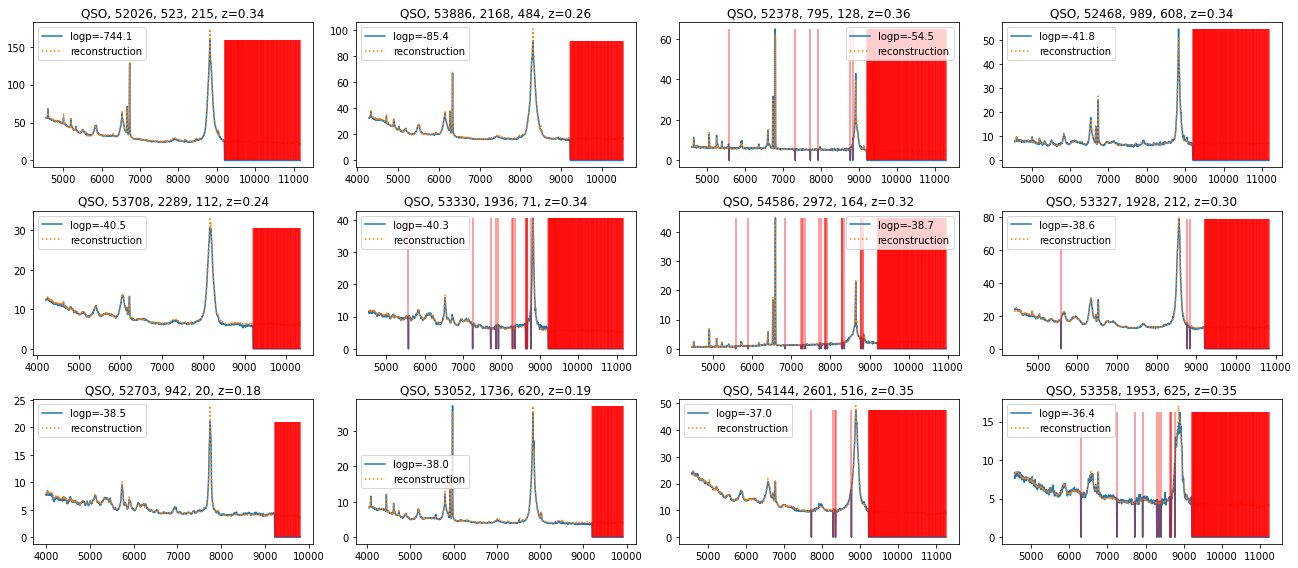

Most Normal Spectra


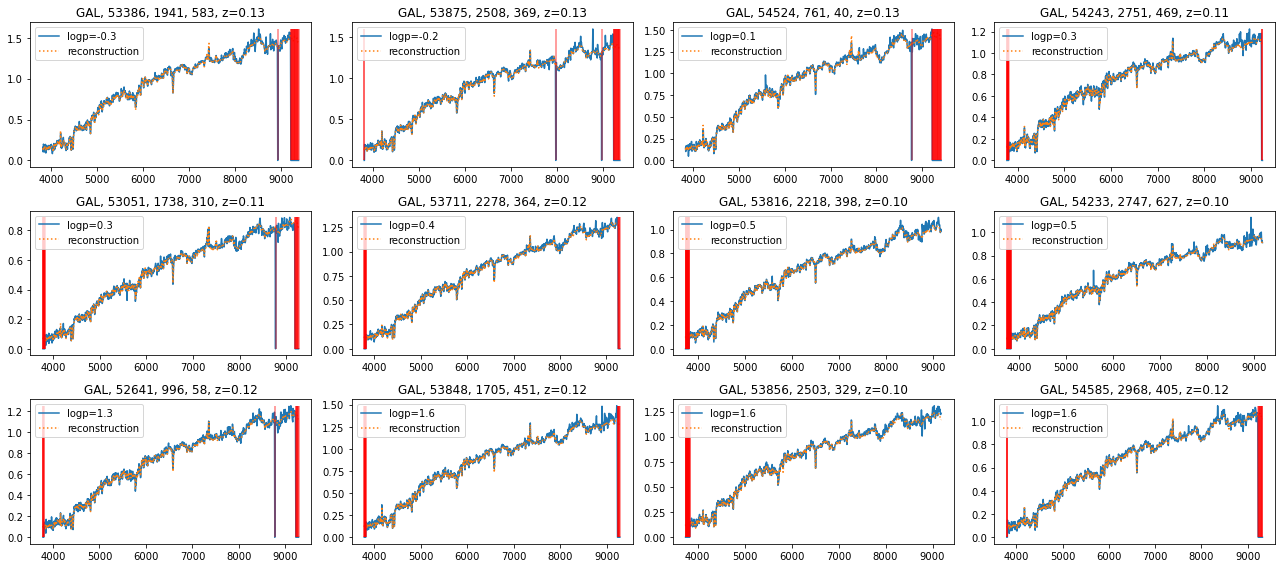

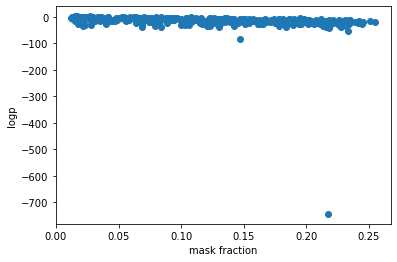

subclass b'STARBURST'


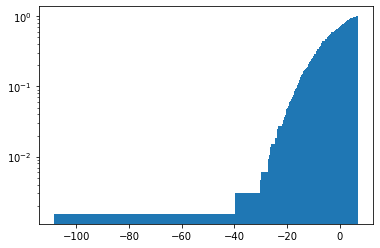

Anomalous Spectra


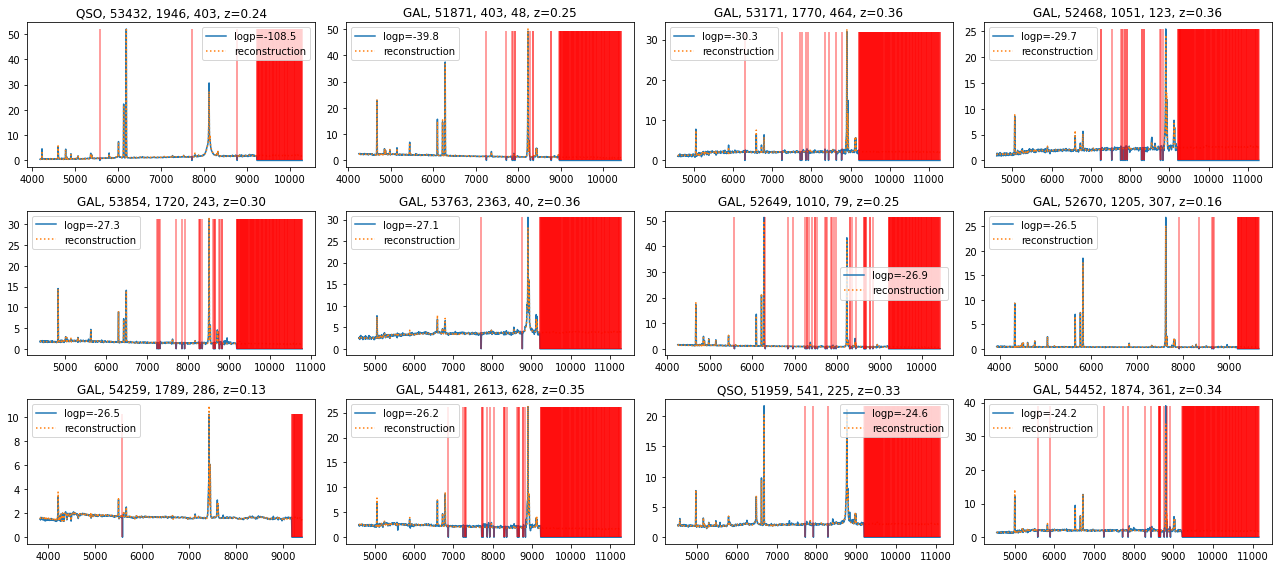

Most Normal Spectra


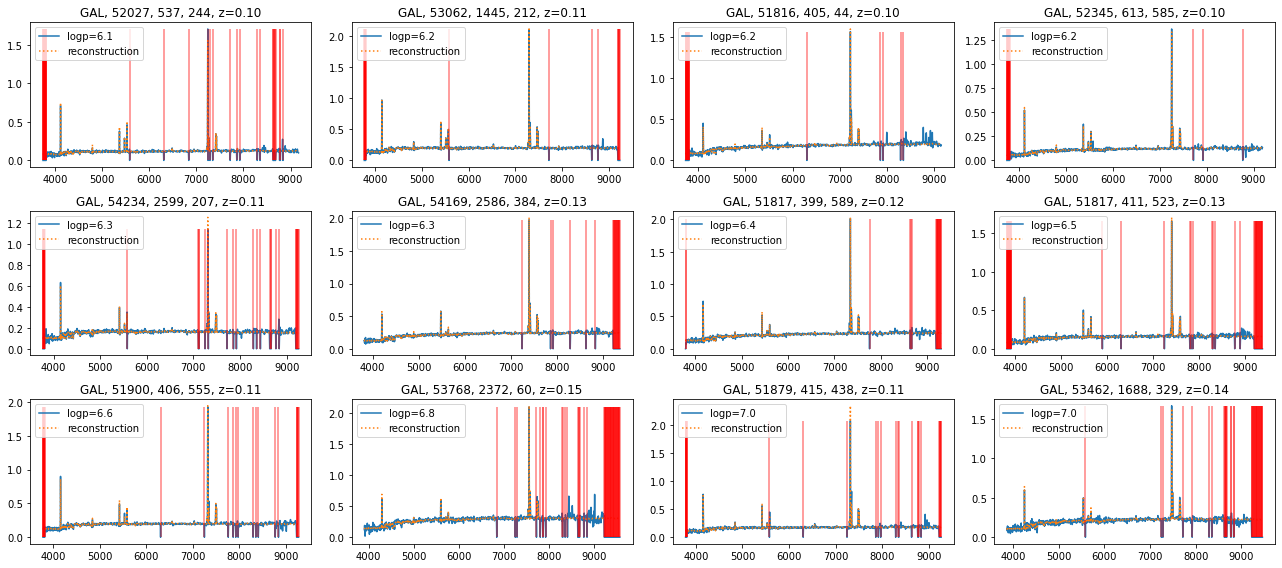

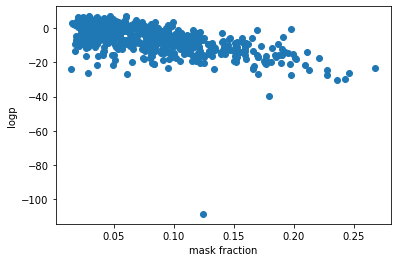

subclass b'STARBURST BROADLINE'


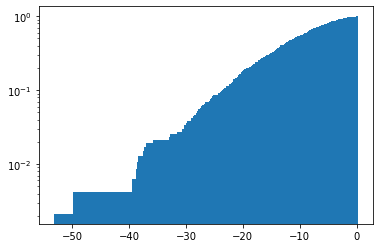

Anomalous Spectra


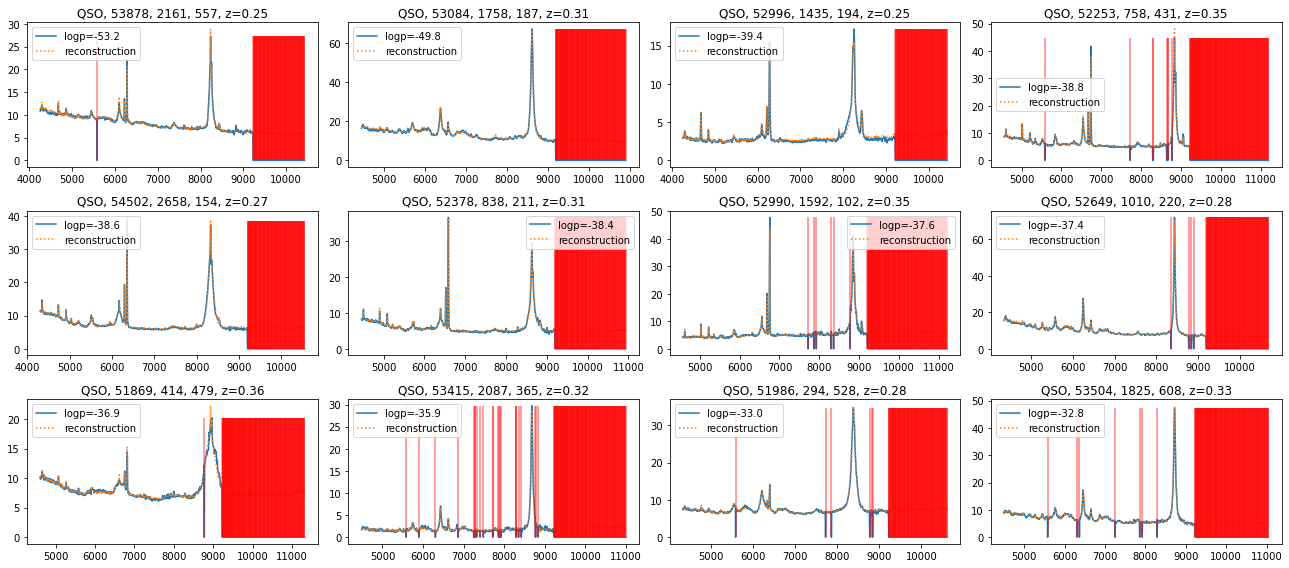

Most Normal Spectra


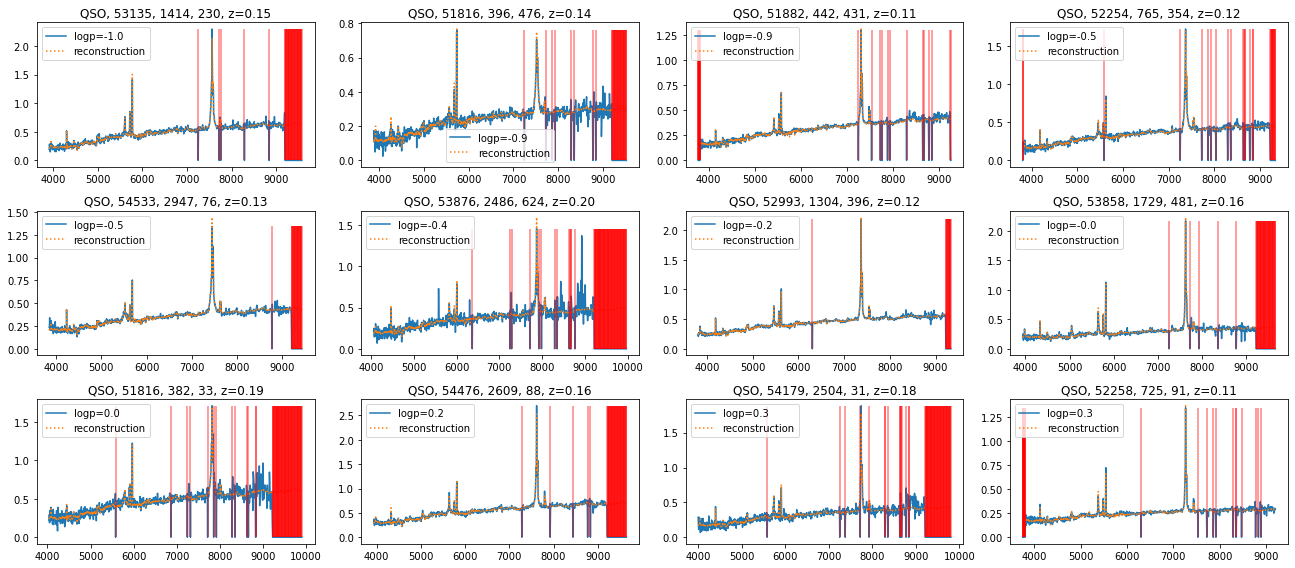

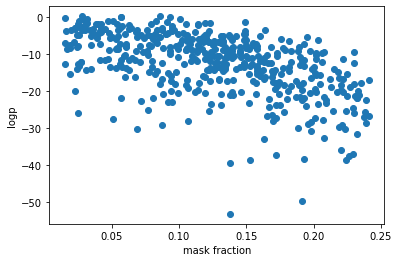

subclass b'STARFORMING'


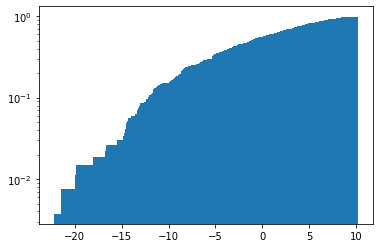

Anomalous Spectra


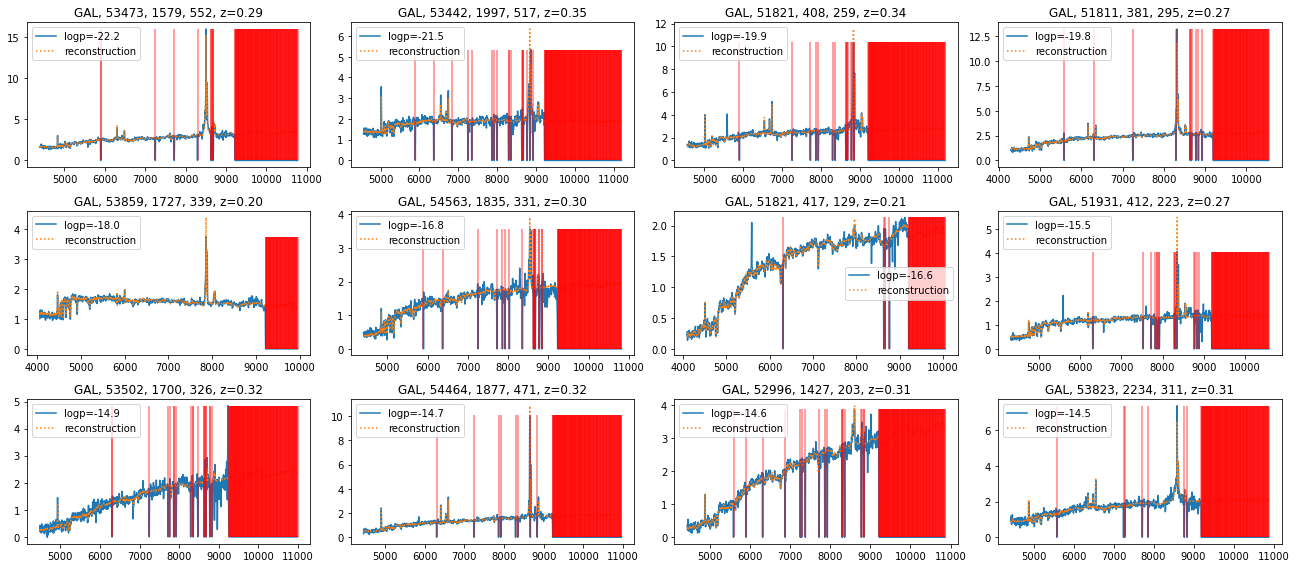

Most Normal Spectra


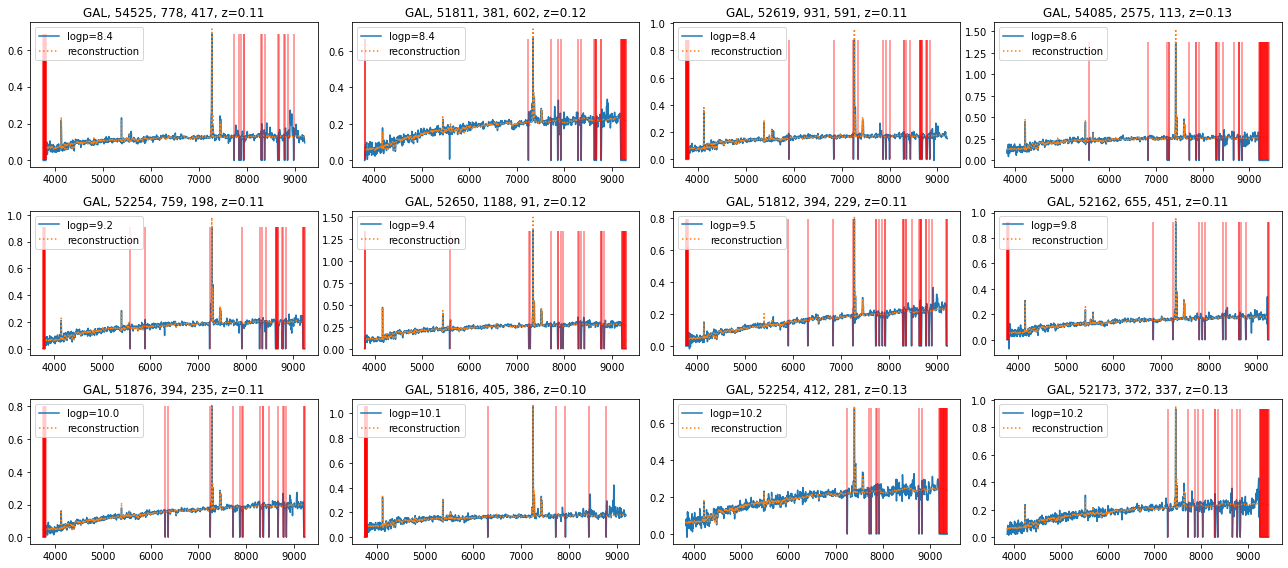

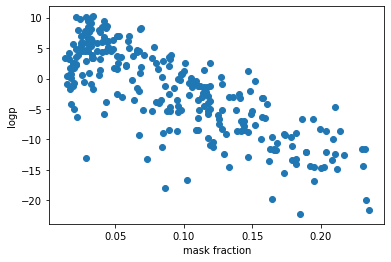

In [41]:
for jj in range(1,7):
    print('subclass %s'%le.inverse_transform([jj])[0])
    ind = np.where(test['subclass']==jj)[0]

    dens            = model.evaluate_density(test_x[ind],test_y[ind]).cpu().numpy()
    ind_ood         = np.argsort(dens)
    dens_sorted     = dens[ind_ood]
    test_x_sorted   = test_x[ind][ind_ood].cpu().numpy()


    cum, bins, _  = plt.hist(dens_sorted,bins=500,density=True, cumulative=True, log=True)
    plt.show()

    outliers          = dens_sorted

    outliers_decoded  = decoded_test[ind][ind_ood]

    outliers_input    = test['spec'][ind][ind_ood]
    wlmin, wlmax    = (3388,8318)
    fixed_num_bins  = 1000
    wl_range        = (np.log10(wlmin),np.log10(wlmax))
    # new binning 
    new_wl          = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

    print('Anomalous Spectra')
    fi, ax = plt.subplots(3,4,figsize=(18,8))
    ax = ax.flatten()
    for ii in range(12):
        ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ind_ood][ii]], test['MJD'][ind][ind_ood][ii],test['plate'][ind][ind_ood][ii],test['fiber'][ind][ind_ood][ii],test['z'][ind][ind_ood][ii]))
        ax[ii].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f'%dens_sorted[ii])
        ax[ii].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls=':')
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~test['mask'][ind][ind_ood][ii].astype(bool))]*(1+test['z'][ind][ind_ood][ii]), ymin=0,ymax=max(test['spec'][ind][ind_ood][ii]), color='red',alpha=0.5,zorder=4)

        ax[ii].legend()
    plt.tight_layout()
    plt.show()

    print('Most Normal Spectra')
    fi, ax = plt.subplots(3,4,figsize=(18,8))
    ax = ax.flatten()
    for nn, ii in enumerate(range(len(ind_ood)-12,len(ind_ood))):
        ax[nn].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ind_ood][ii]], test['MJD'][ind][ind_ood][ii],test['plate'][ind][ind_ood][ii],test['fiber'][ind][ind_ood][ii],test['z'][ind][ind_ood][ii]))
        ax[nn].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f'%dens_sorted[ii])
        ax[nn].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls=':')
        ax[nn].vlines( x=new_wl[1:][np.squeeze(~test['mask'][ind][ind_ood][ii].astype(bool))]*(1+test['z'][ind][ind_ood][ii]), ymin=0,ymax=max(test['spec'][ind][ind_ood][ii]), color='red',alpha=0.5,zorder=4)

        ax[nn].legend()
    plt.tight_layout()
    plt.show()

    mask_fracs = np.sum(~test['mask'].astype('bool'),axis=1)/1000

    plt.xlabel('mask fraction')
    plt.ylabel('logp')
    plt.scatter(mask_fracs[ind][ind_ood],dens_sorted)
    plt.show()

In [11]:
df_extern = pd.read_csv('./external_data/Baronetal_weirdness.csv')

In [12]:
dens      = model.evaluate_density(test_x,test_y).cpu().numpy()

In [13]:
df        = pd.DataFrame.from_dict(dict((k,test[k]) for k in ('MJD','fiber','plate','subclass') if k in test))
df['logp']= dens
df['mask_fracs'] = np.sum(~test['mask'].astype('bool'),axis=1)/1000
df['z'] = test['z']
df['recon_error'] = np.ma.mean(np.ma.array(np.squeeze(test['spec'])-decoded_test,mask=~np.squeeze(test['mask'].astype('bool')))**2,axis=1)
df['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(test['spec'])-decoded_test,mask=~np.squeeze(test['mask'].astype('bool')))**2,axis=1)
df        = df.reset_index()

In [14]:
import sklearn.linear_model
import sklearn.kernel_ridge
LRl = sklearn.linear_model.LinearRegression()
LR = sklearn.kernel_ridge.KernelRidge()

In [17]:
LR.fit(df['mask_fracs'][ind,None],df['logp'][ind,None])
LRl.fit(df['mask_fracs'][ind,None],df['logp'][ind,None])

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


LinearRegression()

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


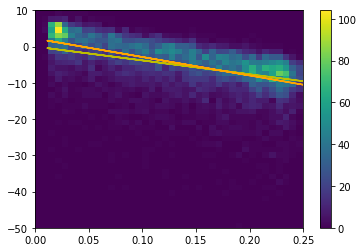

In [18]:
h =plt.hist2d(df['mask_fracs'], df['logp'], range=[[0,0.25],[-50,10]], bins=[40,40])
x= df['mask_fracs']
#plt.plot(x,LR.coef_[0]*x+LR.intercept_[0])
plt.plot(x, LR.predict(x[:,None]),color='y')
plt.plot(x, LRl.predict(x[:,None]),color='orange')
plt.colorbar(h[3])

In [52]:
import scipy.stats
ind = (df['mask_fracs']>0.02)*(df['logp']>-50)
corr, _= scipy.stats.pearsonr(df['mask_fracs'][ind],df['logp'][ind])
print(corr)
df['logp_corr'] = df['logp']-(LRl.coef_[0]*x+LRl.intercept_[0])
corr, _= scipy.stats.pearsonr(df['mask_fracs'][ind],df['logp_corr'][ind])
print(corr)

-0.5352452153714001
-2.0556473190325164e-16


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Text(0.5, 0, 'mask_fracs')

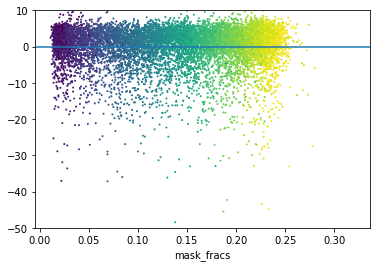

In [53]:
plt.scatter(df['mask_fracs'],df['logp_corr'], s=1, c=df['z'])
plt.axhline(0)
plt.ylim(-50,10)
plt.xlabel('mask_fracs')

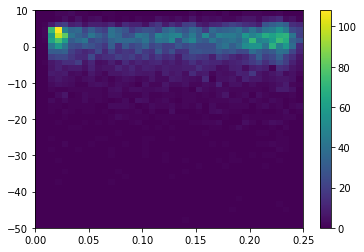

In [54]:
h =plt.hist2d(df['mask_fracs'], df['logp_corr'], range=[[0,0.25],[-50,10]], bins=[40,40])
plt.colorbar()

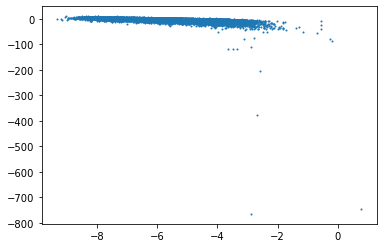

In [55]:
plt.scatter(np.log(df['recon_error']),df['logp'],s=1)

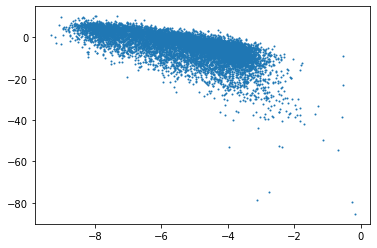

In [56]:
plt.scatter(np.log(df['recon_error'][df['logp']>-100]),df['logp'][df['logp']>-100],s=1)

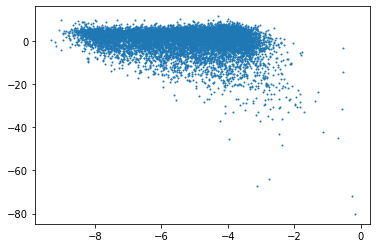

In [57]:
plt.scatter(np.log(df['recon_error'][df['logp_corr']>-100]),df['logp_corr'][df['logp_corr']>-100],s=1)

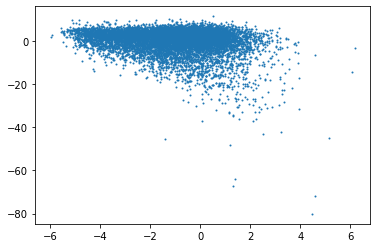

In [58]:
plt.scatter(np.log(df['max_recon_error'][df['logp_corr']>-100]),df['logp_corr'][df['logp_corr']>-100],s=1)

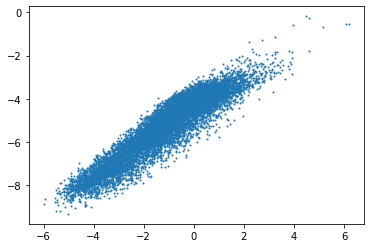

In [59]:
plt.scatter(np.log(df['max_recon_error'][df['logp_corr']>-100]),np.log(df['recon_error'][df['logp_corr']>-100]),s=1)

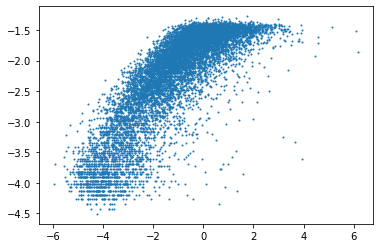

In [60]:
plt.scatter(np.log(df['max_recon_error'][df['logp_corr']>-100]),np.log(df['mask_fracs'][df['logp_corr']>-100]),s=1)

### Mask fraction corrected logp

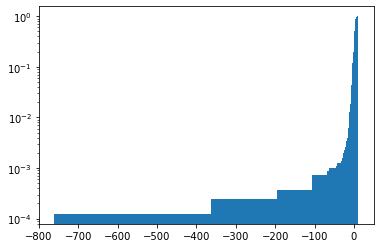

Anomalous Spectra


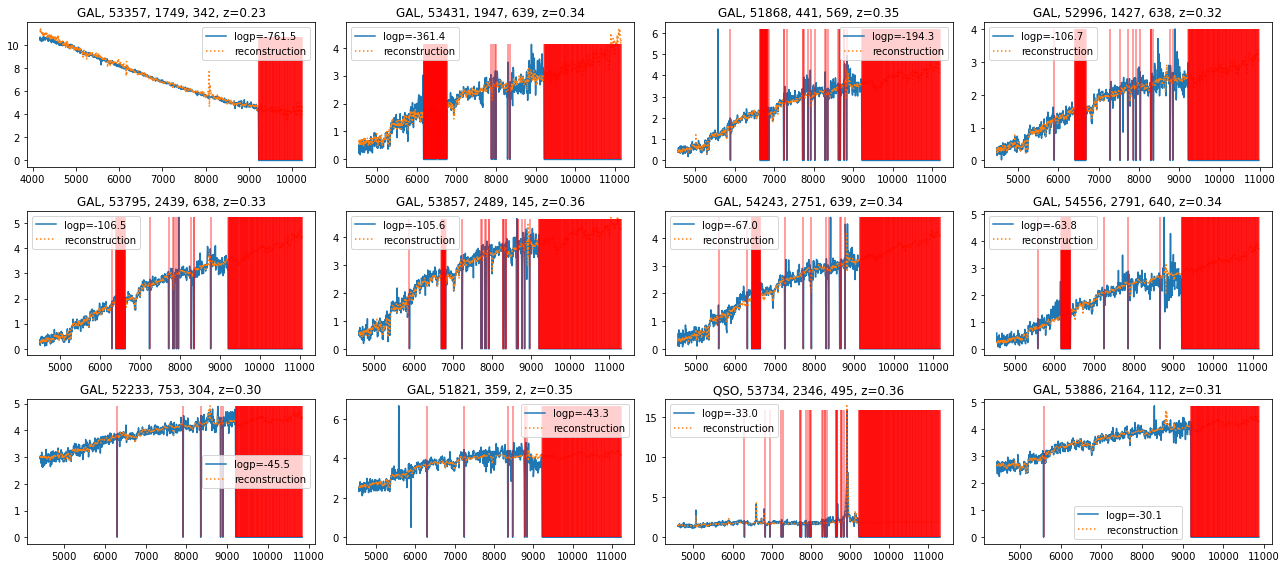

Most Normal Spectra


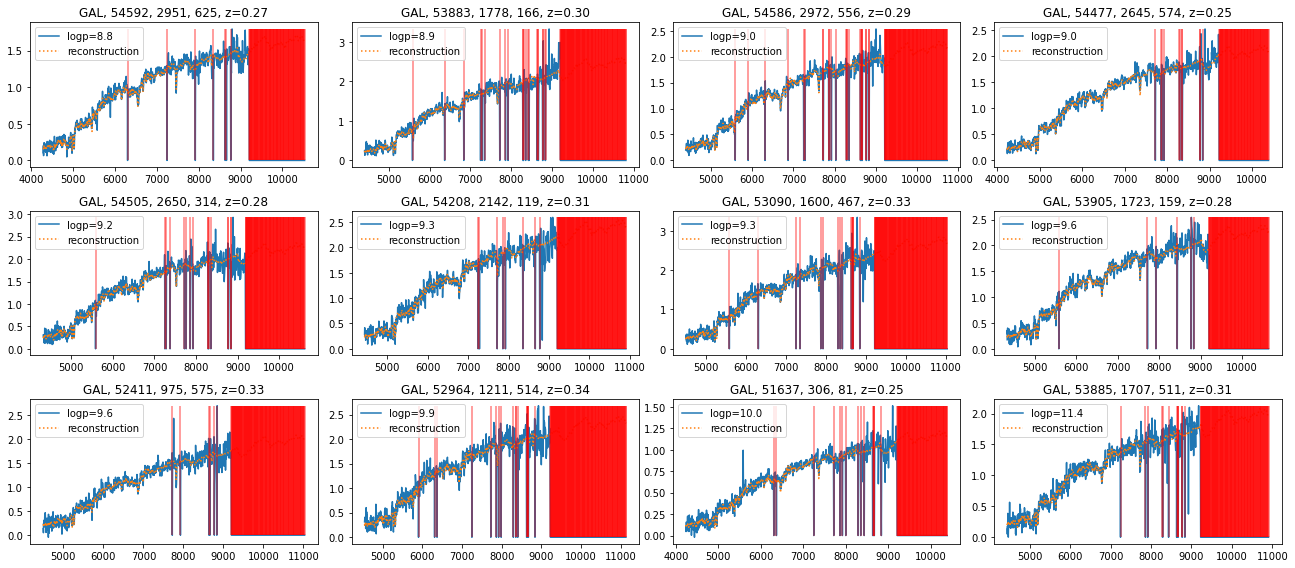

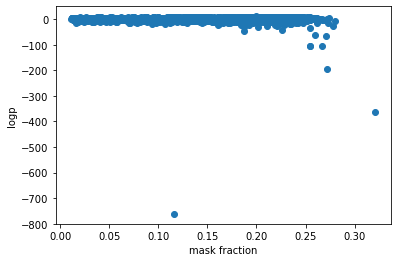

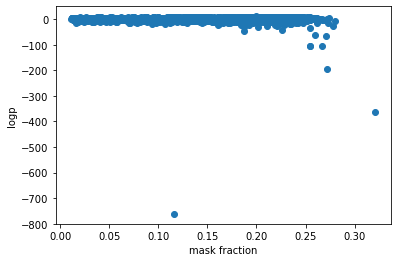

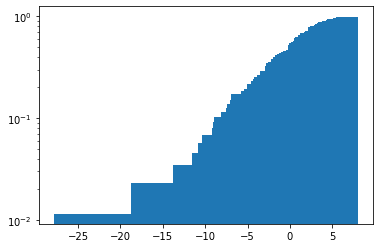

Anomalous Spectra


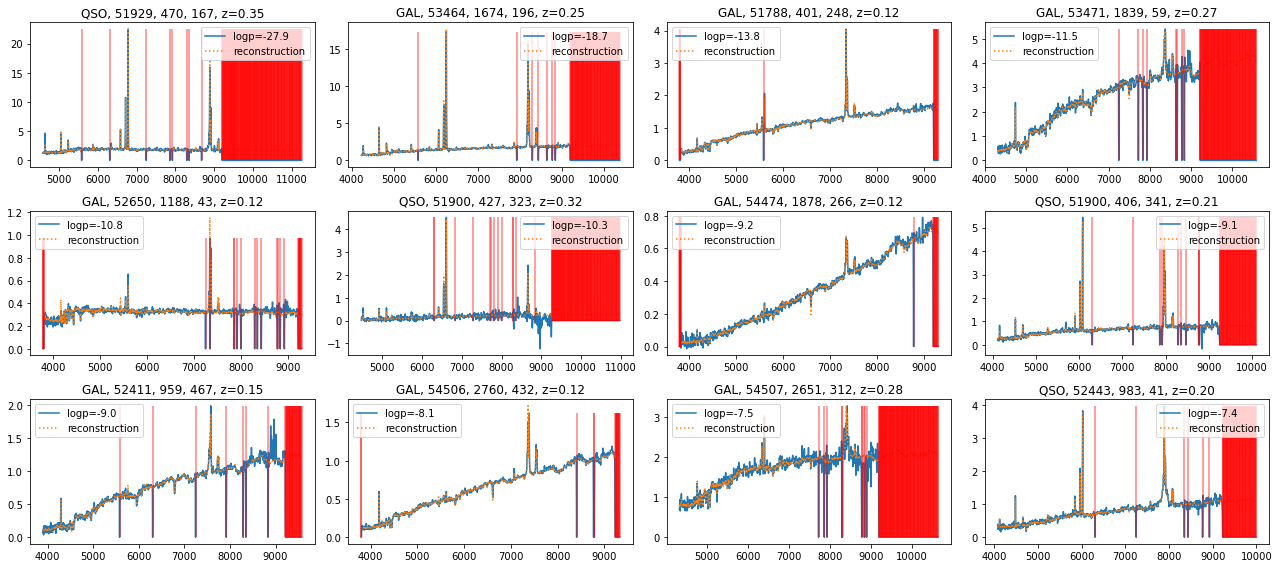

Most Normal Spectra


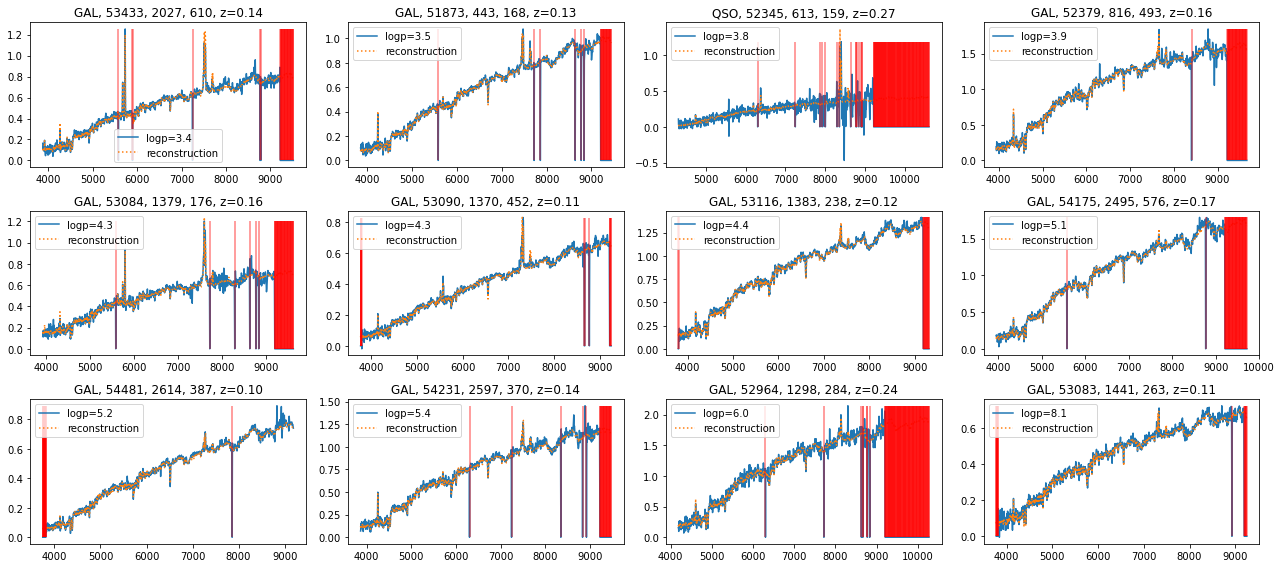

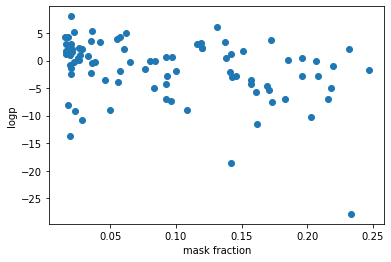

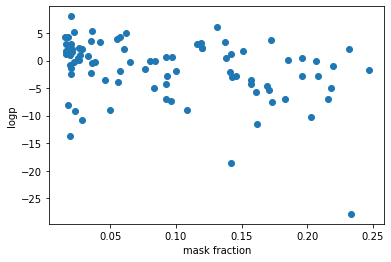

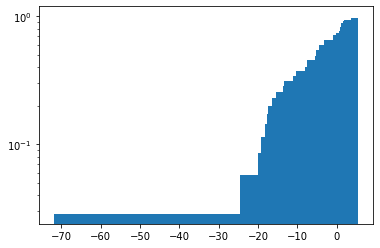

Anomalous Spectra


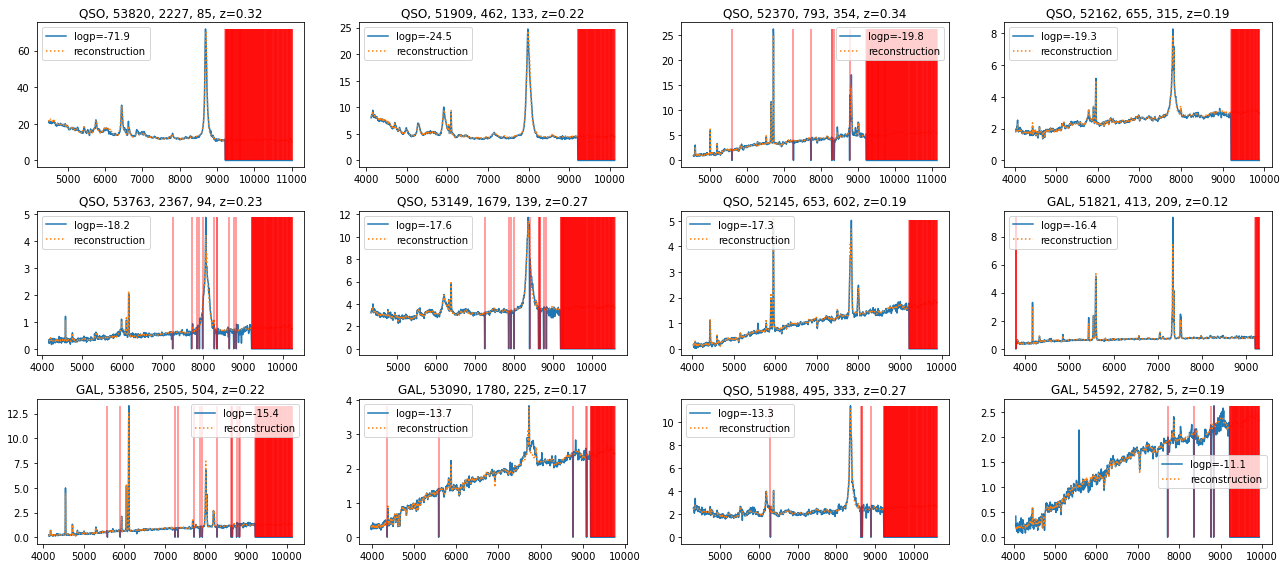

Most Normal Spectra


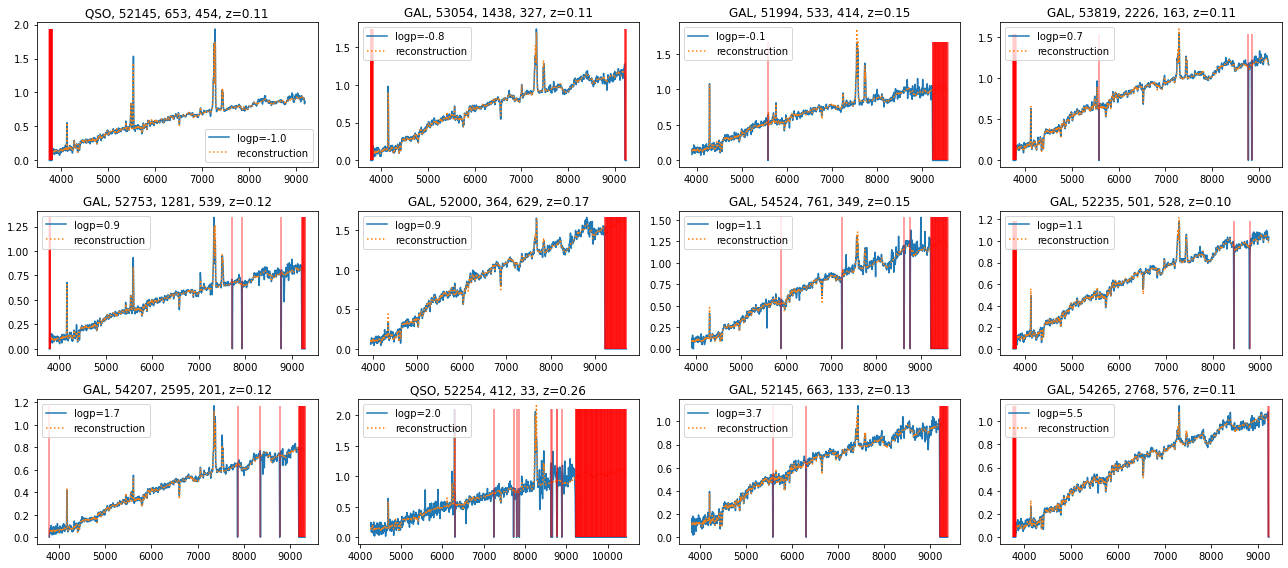

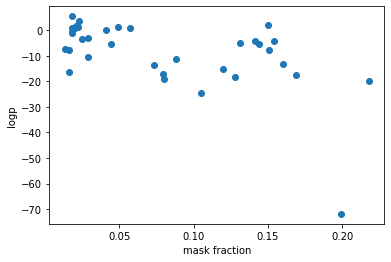

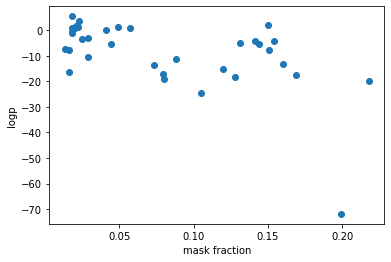

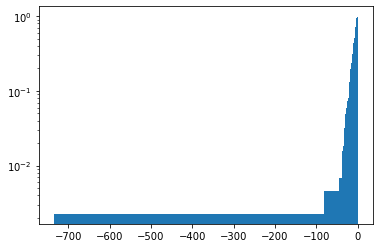

Anomalous Spectra


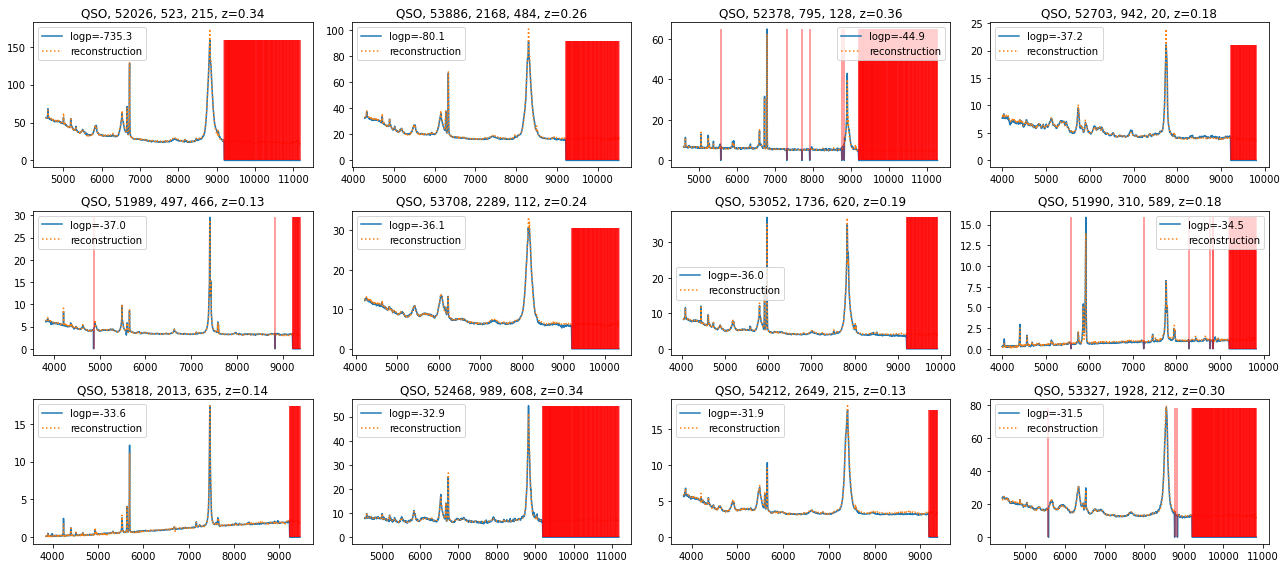

Most Normal Spectra


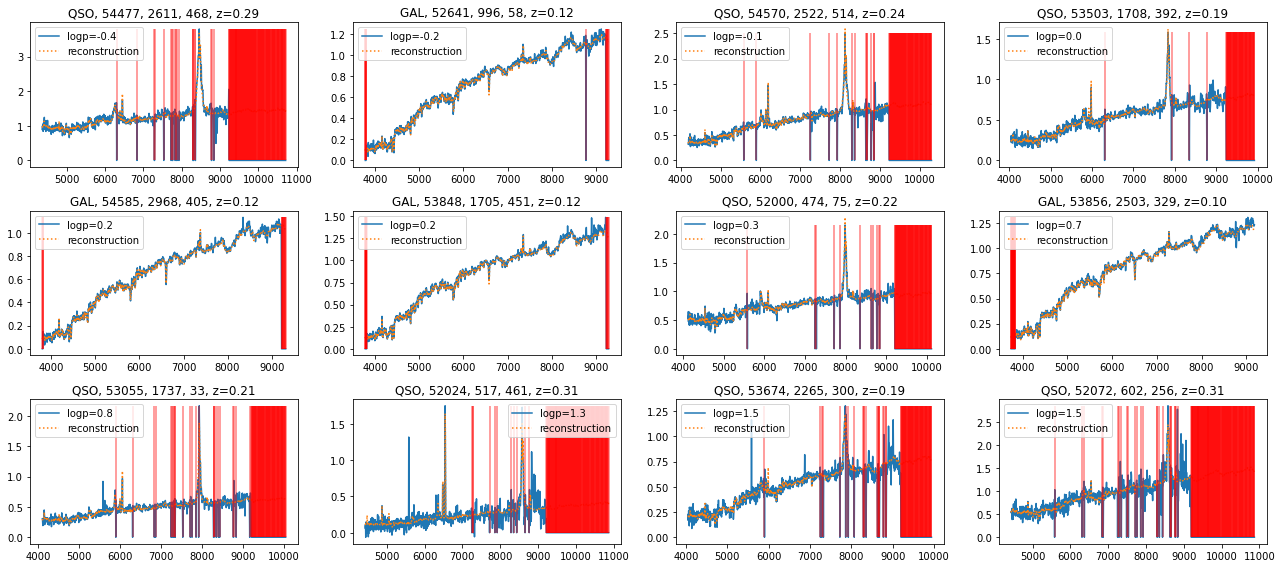

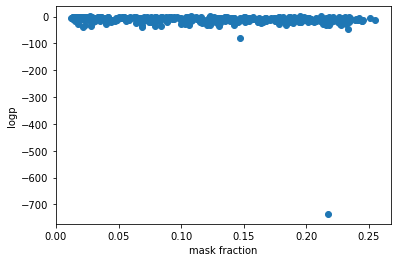

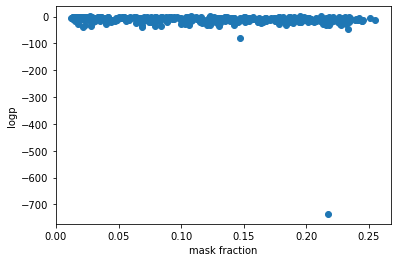

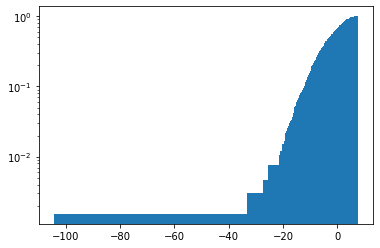

Anomalous Spectra


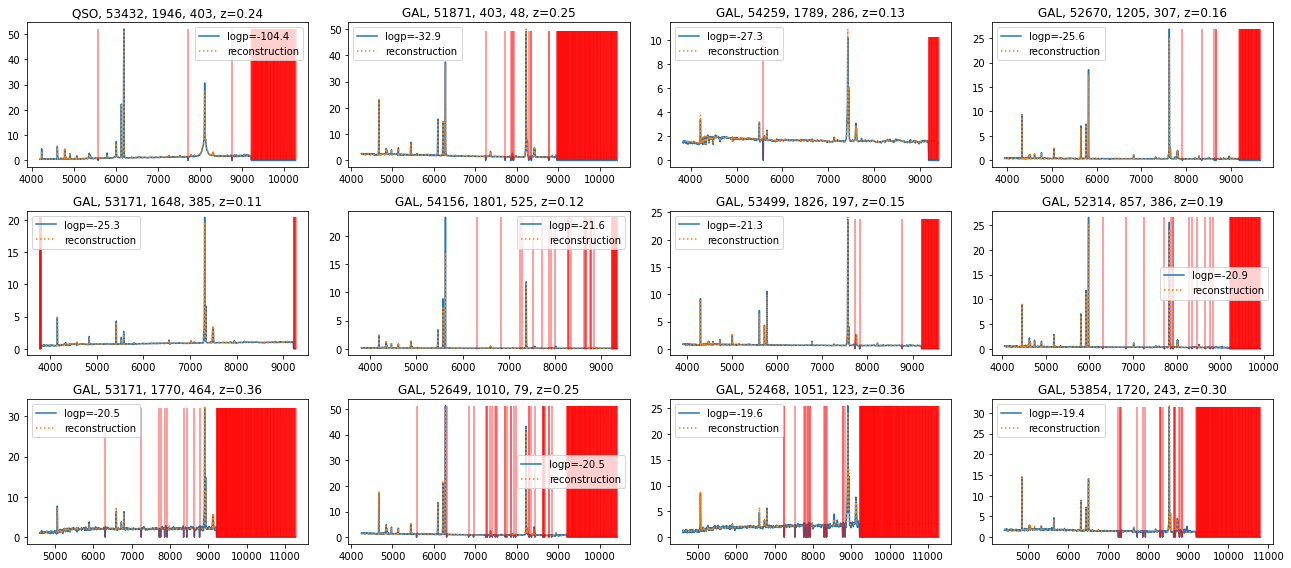

Most Normal Spectra


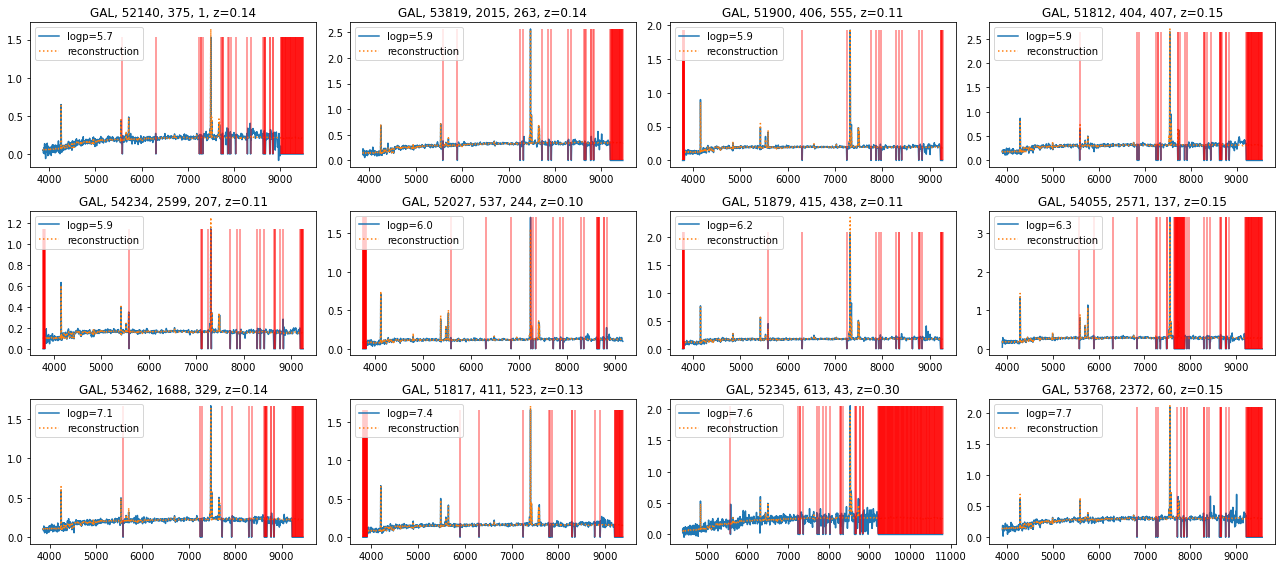

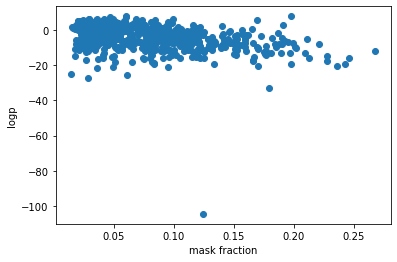

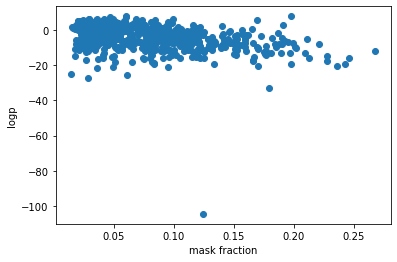

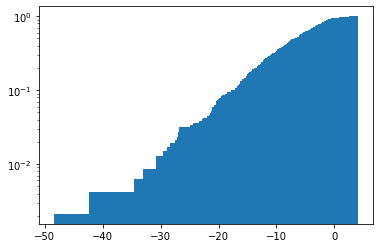

Anomalous Spectra


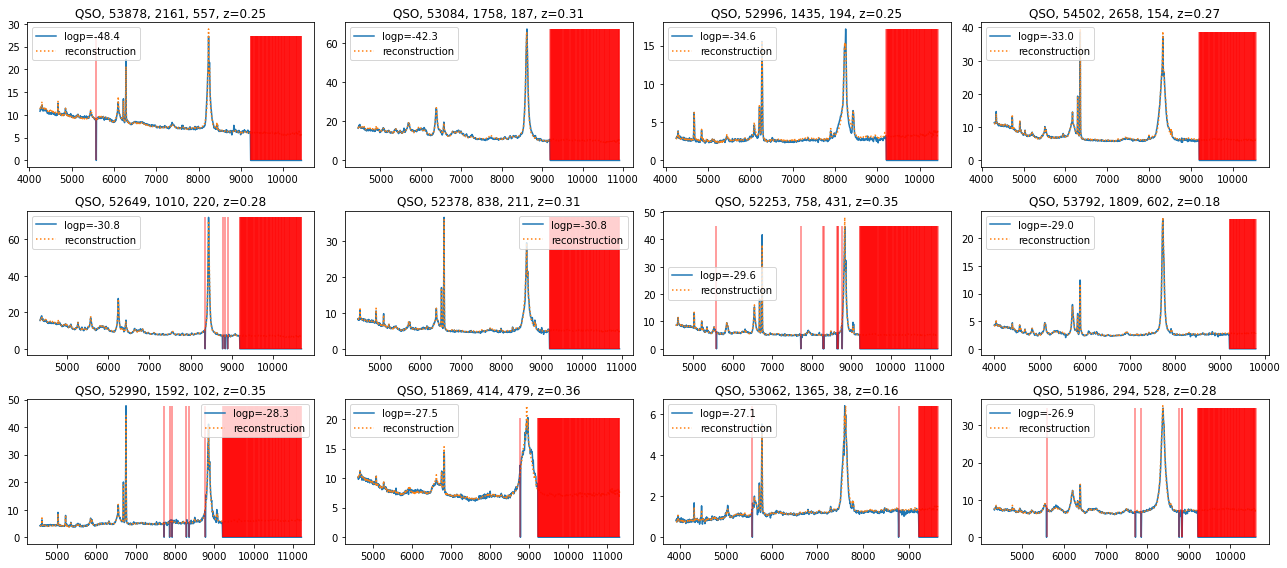

Most Normal Spectra


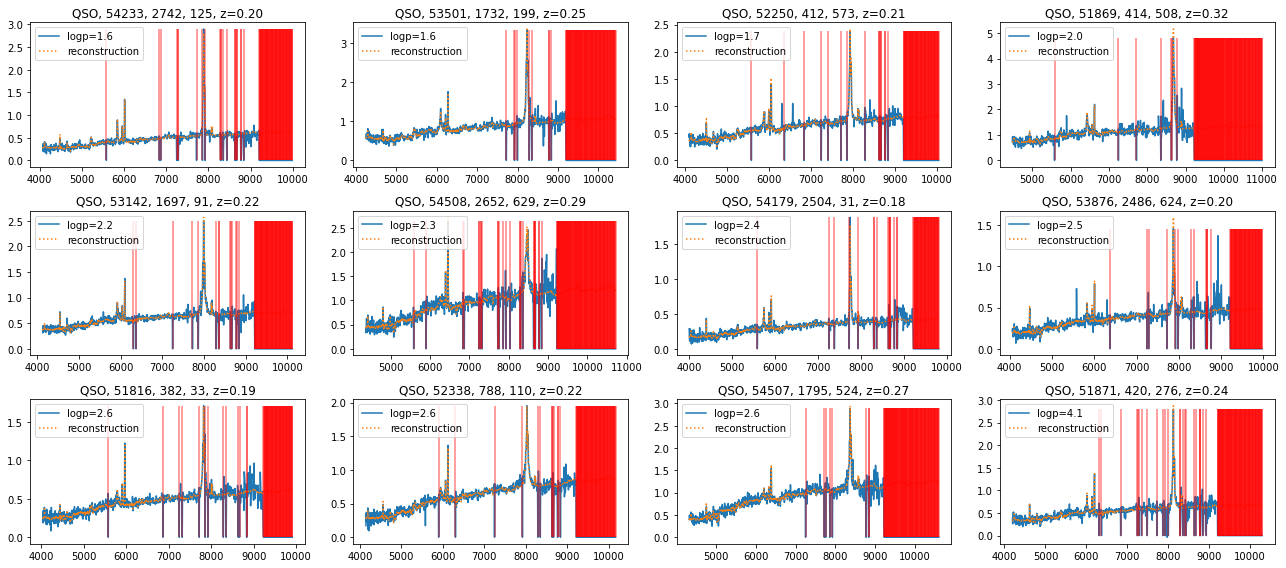

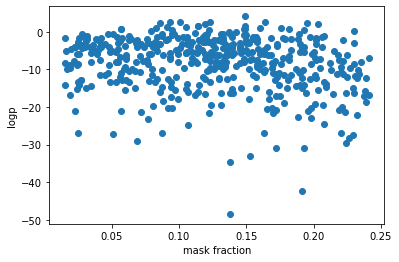

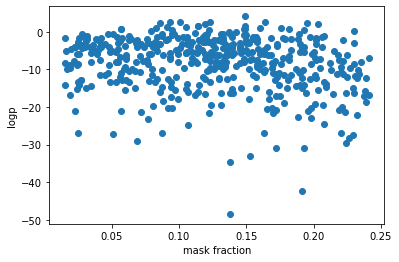

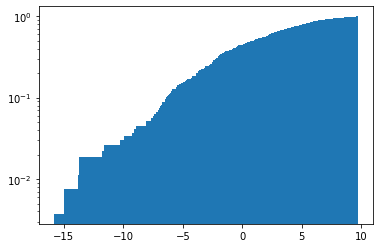

Anomalous Spectra


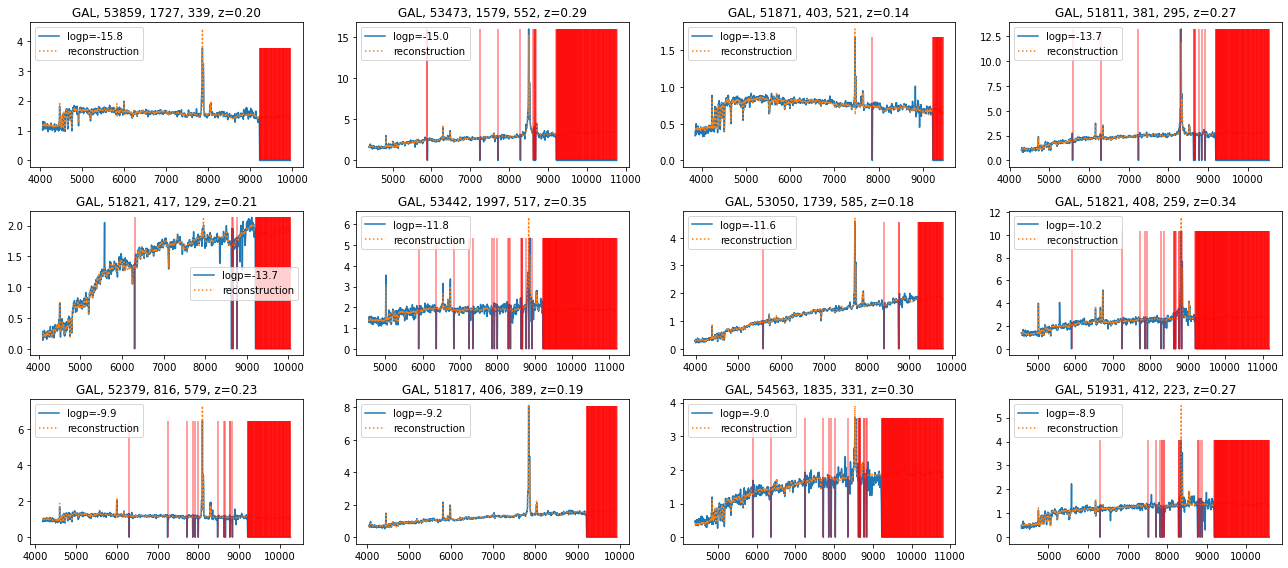

Most Normal Spectra


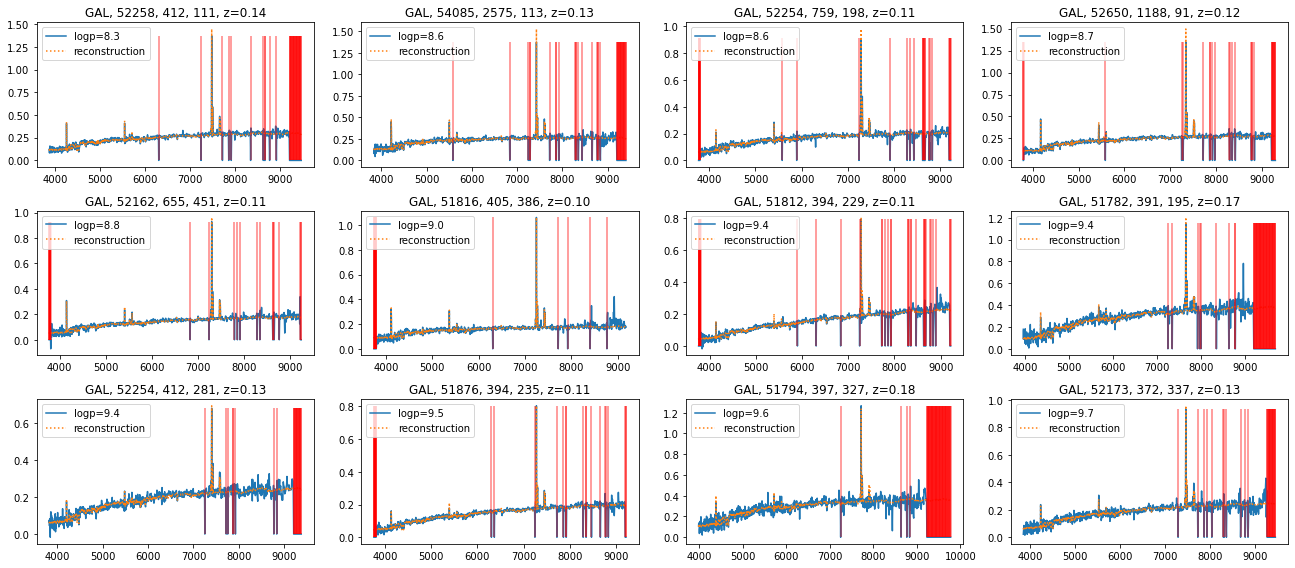

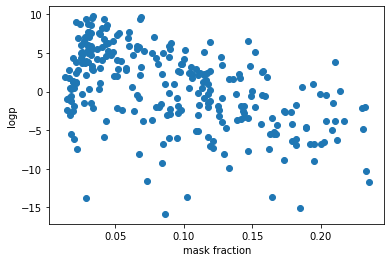

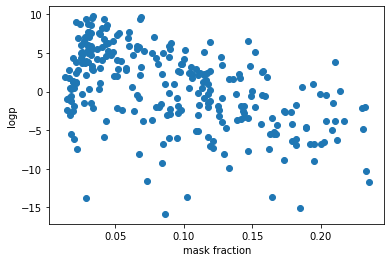

In [64]:

for mm in range(7):
    ind = np.where(test['subclass']==mm)[0]

    mask_fracs      = np.sum(~test['mask'].astype('bool'),axis=1)/1000

    dens            = model.evaluate_density(test_x[ind],test_y[ind]).cpu().numpy()
    correction      = (LRl.coef_[0]*mask_fracs[ind]+LRl.intercept_[0])
    dens            = dens-np.squeeze(correction)

    ind_ood         = np.argsort(dens)
    dens_sorted     = dens[ind_ood]
    test_x_sorted   = test_x[ind][ind_ood].cpu().numpy()


    cum, bins, _      = plt.hist(dens_sorted,bins=500,density=True, cumulative=True, log=True)
    plt.show()

    outliers_decoded  = decoded_test[ind][ind_ood]
    outliers_input    = test['spec'][ind][ind_ood]

    wlmin, wlmax      = (3388,8318)
    fixed_num_bins    = 1000
    wl_range          = (np.log10(wlmin),np.log10(wlmax))
    # new binning 
    new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)


    print('Anomalous Spectra')
    fi, ax = plt.subplots(3,4,figsize=(18,8))
    ax = ax.flatten()
    for ii in range(12):
        ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ind_ood][ii]], test['MJD'][ind][ind_ood][ii],test['plate'][ind][ind_ood][ii],test['fiber'][ind][ind_ood][ii],test['z'][ind][ind_ood][ii]))
        ax[ii].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f'%dens_sorted[ii])
        ax[ii].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls=':')
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~test['mask'][ind][ind_ood][ii].astype(bool))]*(1+test['z'][ind][ind_ood][ii]), ymin=0,ymax=max(test['spec'][ind][ind_ood][ii]), color='red',alpha=0.5,zorder=4)

        ax[ii].legend()
    plt.tight_layout()
    plt.show()

    print('Most Normal Spectra')
    fi, ax = plt.subplots(3,4,figsize=(18,8))
    ax = ax.flatten()
    for nn, ii in enumerate(range(len(ind_ood)-12,len(ind_ood))):
        ax[nn].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ind_ood][ii]], test['MJD'][ind][ind_ood][ii],test['plate'][ind][ind_ood][ii],test['fiber'][ind][ind_ood][ii],test['z'][ind][ind_ood][ii]))
        ax[nn].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f'%dens_sorted[ii])
        ax[nn].plot(new_wl[1:]*(test['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls=':')
        ax[nn].vlines( x=new_wl[1:][np.squeeze(~test['mask'][ind][ind_ood][ii].astype(bool))]*(1+test['z'][ind][ind_ood][ii]), ymin=0,ymax=max(test['spec'][ind][ind_ood][ii]), color='red',alpha=0.5,zorder=4)

        ax[nn].legend()
    plt.tight_layout()
    plt.show()

    mask_fracs = np.sum(~test['mask'].astype('bool'),axis=1)/1000

    plt.xlabel('mask fraction')
    plt.ylabel('logp')
    plt.scatter(mask_fracs[ind][ind_ood],dens_sorted)
    plt.show()



    plt.xlabel('mask fraction')
    plt.ylabel('logp')
    plt.scatter(mask_fracs[ind][ind_ood],dens_sorted)
    plt.show()

In [66]:
df.columns, df_extern.columns

(Index(['index', 'MJD', 'fiber', 'plate', 'subclass', 'logp', 'mask_fracs', 'z',
        'recon_error', 'max_recon_error', 'logp_corr'],
       dtype='object'),
 Index(['plate', ' mjd', ' fiber', ' weirdness'], dtype='object'))

In [67]:
df.rename(columns={'MJD':' mjd', 'fiber':' fiber'}, inplace=True)

In [68]:
df_overlap = df_extern.merge(df,how='inner',on=['plate',' mjd',' fiber'])

In [70]:
scipy.stats.pearsonr(df_overlap['logp'],df_overlap[' weirdness']), scipy.stats.pearsonr(df_overlap['logp_corr'],df_overlap[' weirdness'])

((-0.24201114459500953, 1.1616026271459338e-115),
 (-0.14119225924170126, 8.288330557712603e-40))

Text(0, 0.5, '-logp')

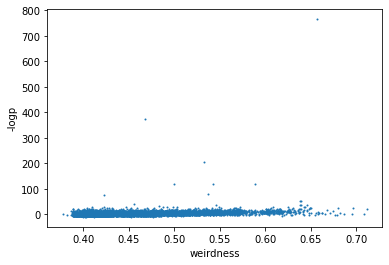

In [71]:
plt.scatter(df_overlap[' weirdness'],-df_overlap['logp'],s=1)
plt.xlabel('weirdness')
plt.ylabel('-logp')

In [72]:
df_overlap_cut = df_overlap[df_overlap['logp']>-50]

Text(0, 0.5, '-logp')

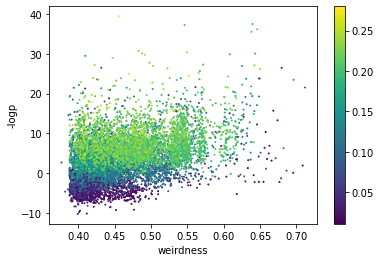

In [73]:
plt.scatter(df_overlap_cut[' weirdness'],-df_overlap_cut['logp'],s=1,c=df_overlap_cut['mask_fracs'])
plt.colorbar()
plt.xlabel('weirdness')
plt.ylabel('-logp')

Text(0, 0.5, '-logp')

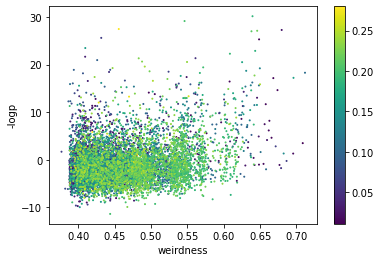

In [74]:
plt.scatter(df_overlap_cut[' weirdness'],-df_overlap_cut['logp_corr'],s=1,c=df_overlap_cut['mask_fracs'])
plt.colorbar()
plt.xlabel('weirdness')
plt.ylabel('-logp')

Text(0, 0.5, '-logp')

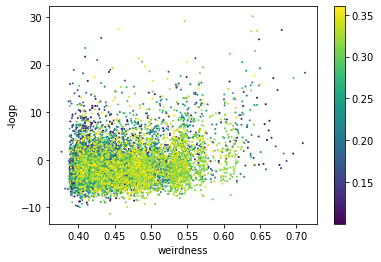

In [75]:
plt.scatter(df_overlap_cut[' weirdness'],-df_overlap_cut['logp_corr'],s=1,c=df_overlap_cut['z'])
plt.colorbar()
plt.xlabel('weirdness')
plt.ylabel('-logp')

Text(0, 0.5, 'recon error')

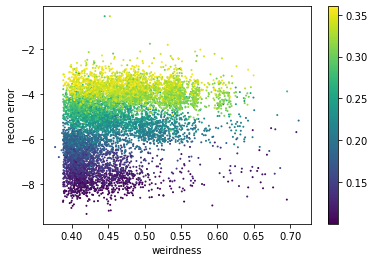

In [76]:
plt.scatter(df_overlap_cut[' weirdness'],np.log(df_overlap_cut['recon_error']),s=1,c=df_overlap_cut['z'])
plt.colorbar()
plt.xlabel('weirdness')
plt.ylabel('recon error')

Text(0, 0.5, '-logp')

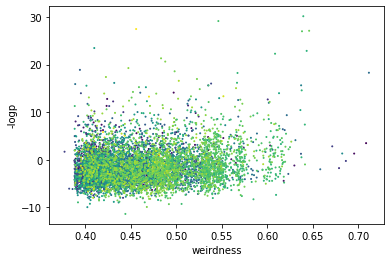

In [77]:
df_overlap_cut = df_overlap_cut[df_overlap_cut['subclass']==0]
plt.scatter(df_overlap_cut[' weirdness'],-df_overlap_cut['logp_corr'],s=1,c=df_overlap_cut['mask_fracs'])
plt.xlabel('weirdness')
plt.ylabel('-logp')

Text(0, 0.5, '-logp')

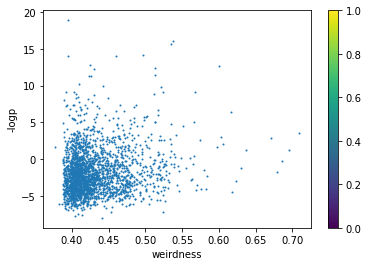

In [78]:
df_overlap_cut = df_overlap_cut[df_overlap_cut['mask_fracs']<0.1]
plt.scatter(df_overlap_cut[' weirdness'],-df_overlap_cut['logp_corr'],s=1)
plt.colorbar()
plt.xlabel('weirdness')
plt.ylabel('-logp')

In [79]:
high_weird_high_logp = df_overlap[(df_overlap[' weirdness']>0.69)*(df_overlap['logp_corr']>-2)]

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [80]:
high_weird_high_logp['logp'], dens[high_weird_high_logp['index']]

(1950   -0.093132
 Name: logp, dtype: float32,
 array([1.76261638]))

In [81]:
high_weird_high_logp[' mjd'], test['MJD'][high_weird_high_logp['index']], high_weird_high_logp['index']

(1950    52761.0
 Name:  mjd, dtype: float64,
 array([52761]),
 1950    99
 Name: index, dtype: int64)

### High weirdness, high probability

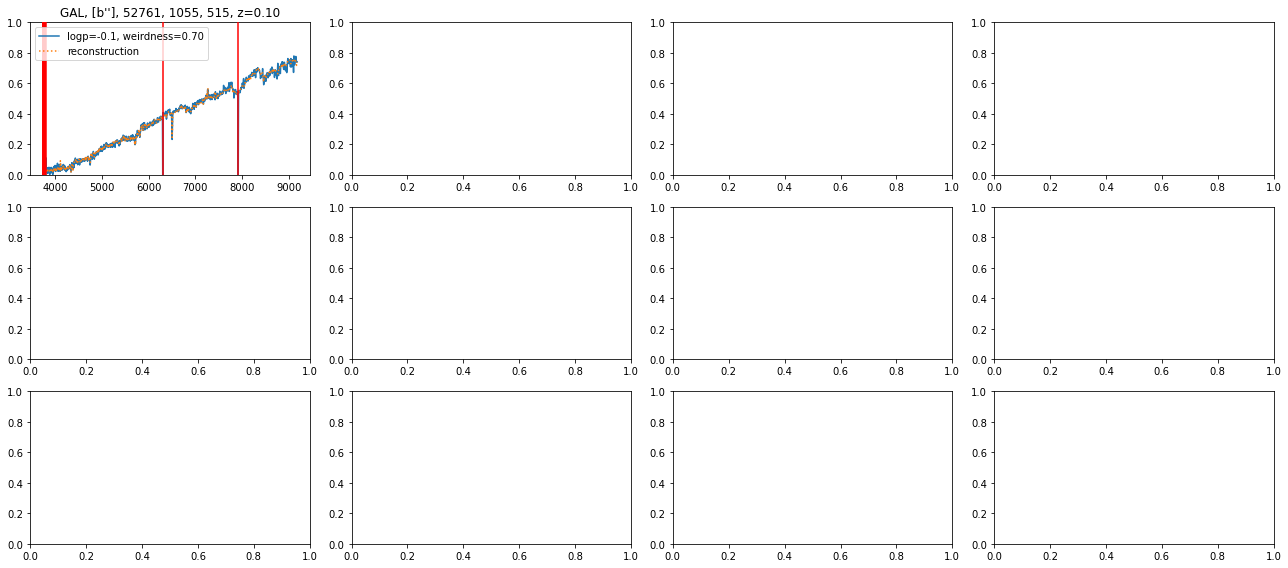

In [99]:
ind   = high_weird_high_logp['index']
weird = high_weird_high_logp[' weirdness']
logp  = high_weird_high_logp.logp

fi, ax = plt.subplots(3,4,figsize=(18,8))
ax = ax.flatten()
for ii in range(len(high_weird_high_logp)):
    nn = ind.iloc[ii]
    ax[ii].set_title('%s, %s, %d, %d, %d, z=%.2f'%(classes[test['class'][nn]], le.inverse_transform([test['subclass'][nn]]), test['MJD'][nn],test['plate'][nn],test['fiber'][nn],test['z'][nn]))
    ax[ii].plot(new_wl[1:]*(1+test['z'][nn]),test['spec'][nn],label='logp=%.1f, weirdness=%.2f'%(logp.iloc[ii],weird.iloc[ii]))
    ax[ii].plot(new_wl[1:]*(1+test['z'][nn]),decoded_test[nn], label='reconstruction',ls=':')
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~test['mask'][nn].astype(bool))]*(1+test['z'][nn]), ymin=0,ymax=1, color='red',zorder=3)
    ax[ii].set_ylim(0,1)
    ax[ii].legend()
plt.tight_layout()
plt.show()

In [83]:
(new_wl[1:][np.squeeze(~test['mask'][nn].astype(bool))]*(1+test['z'][nn])).shape

(20,)

In [84]:
low_weird_low_logp = df_overlap[(df_overlap[' weirdness']<0.45)*(df_overlap['logp_corr']<-20)]

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [88]:
low_weird_low_logp

plate      mjd   fiber   weirdness  index  subclass       logp  \
2708  1205.0  52670.0   307.0    0.431749    147         4 -26.484337   
2801  1801.0  54156.0   525.0    0.409654   8600         4 -21.254690   
2833   857.0  52314.0   386.0    0.426185   9743         4 -23.548876   
5370  2369.0  53733.0   287.0    0.409823   5012         0 -29.445955   
8249  2791.0  54556.0   640.0    0.422847   9318         0 -74.790459   

      mask_fracs         z  recon_error  max_recon_error  logp_corr  
2708       0.061  0.161057     0.007665         2.909791 -25.597345  
2801       0.036  0.123465     0.045505        38.713354 -21.641426  
2833       0.095  0.192887     0.016096         3.881732 -20.929615  
5370       0.161  0.258132     0.012160         1.246955 -23.464054  
8249       0.260  0.341244     0.062685         4.094015 -63.764598

2708     147
2801    8600
2833    9743
5370    5012
8249    9318
Name: index, dtype: int64


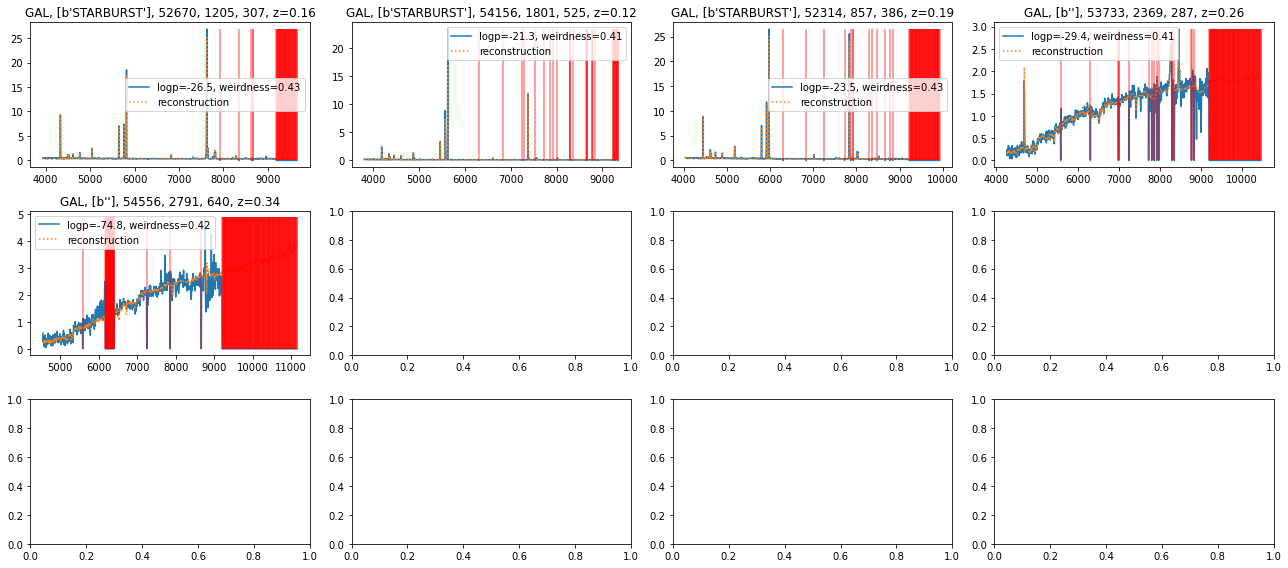

In [98]:
ind   = low_weird_low_logp['index']
weird = low_weird_low_logp[' weirdness']
logp  = low_weird_low_logp.logp

fi, ax = plt.subplots(3,4,figsize=(18,8))
ax = ax.flatten()
for ii in range(min(len(low_weird_low_logp),12)):
    nn = ind.iloc[ii]
    ax[ii].set_title('%s, %s, %d, %d, %d, z=%.2f'%(classes[test['class'][nn]], le.inverse_transform([test['subclass'][nn]]), test['MJD'][nn],test['plate'][nn],test['fiber'][nn],test['z'][nn]))
    ax[ii].plot(new_wl[1:]*(1+test['z'][nn]),test['spec'][nn],label='logp=%.1f, weirdness=%.2f'%(logp.iloc[ii],weird.iloc[ii]))
    ax[ii].plot(new_wl[1:]*(1+test['z'][nn]),decoded_test[nn], label='reconstruction',ls=':')
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~test['mask'][nn].astype(bool))]*(1+test['z'][nn]), ymin=0,ymax=max(test['spec'][nn]), color='red',alpha=0.5,zorder=4)

    ax[ii].legend()
plt.tight_layout()
plt.show()